In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import logistic
from sklearn.metrics import accuracy_score
from pytorch_lightning import seed_everything
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings

from functools import partial
warnings.filterwarnings('ignore')
seed_rand = 765
seed_everything(seed_rand)
import matplotlib.pyplot as plt
from lime_explainer import LimeTabularExplainerReview as LimeTabularExplainer,pyplot_figure
from pathwise_contributions import PathwiseContributionLimeExplanations,collapseAttributions,distributeLocalContributions
from explanations_utils import Predictor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

#'https://raw.githubusercontent.com/Caspian-Ltd/Bayesian_stress_testing/master/data/bs140513_032310.csv'

df_bank= pd.read_csv('bs140513_032310.csv')
#df_bank.to_csv('bs140513_032310.csv')
del df_bank['zipMerchant']
del df_bank['zipcodeOri']

df_bank['category']=df_bank['category'].str.strip("'")
df_bank['merchant']=df_bank['merchant'].str.strip("'")
df_bank['age']=df_bank['age'].str.strip("'")
df_bank['gender']=df_bank['gender'].str.strip("'")
df_bank['customer']=df_bank['customer'].str.strip("'")

nature_of_bus_lbl = LabelEncoder().fit(df_bank['category'])

#calculate nature of business risk
risk_per_nob = {}
for b in df_bank.category.unique():
    t_df = df_bank[df_bank['category']==b]
    ratio = t_df[t_df['fraud']==1].shape[0] / t_df.shape[0]
    risk_per_nob[b] = ratio


nob_risks=np.asarray(list(risk_per_nob.values()))

def risk_to_label(risk):
    if risk <=0.2:
        if np.random.rand() >0.1:
            return 'low'
    if risk<=0.7:
        if np.random.rand() >0.1:
            return 'medium'
    return 'high'

df_nob = df_bank[['amount','category']]
df_nob['risk_label']=df_nob['category'].apply(lambda x :risk_to_label(risk_per_nob[x]))

# build a classifier for nature of business risk
nob_cat_encoder = OneHotEncoder().fit(np.asarray(df_nob['category']).reshape(-1,1))

df_nob['lbl'] =  LabelEncoder().fit_transform(df_nob['risk_label'])
cat_feature = nob_cat_encoder.transform(np.asarray(df_nob['category']).reshape(-1,1)).toarray()

feature_names_nob = np.append(nob_cat_encoder.categories_,['amount'])
data_nob = np.hstack((cat_feature,np.asarray(df_nob['amount']).reshape(-1,1)))
data_nob = pd.DataFrame(columns = feature_names_nob,data=data_nob)

def extract_frequency_features(transaction,cust_df):
    #count the number of times the cp has been transacted with before
    mer = transaction['merchant']
    mer_data = cust_df[cust_df['merchant']==mer]
    
    tr_count = mer_data.shape[0]
    mer_time_stamps = np.array(mer_data['step'])
    avg_amount = np.mean(mer_data['amount'])
    std_amount = np.std(mer_data['amount'])
    
    return tr_count,mer_time_stamps,avg_amount,std_amount,mer_data



#simulate n points of the distrubtion to be able to measure the probability of a point
def estimate_probability(_param,sample,n=10000):
    samples = scipy.stats.lognorm.rvs(*_param[:-2], 
                       loc=_param[-2], scale=_param[-1], size=n)
    return len(samples[samples<sample])/n


# gender encoder
gender_encoder = LabelEncoder().fit(df_bank['gender'])


# to speed the feature extraction we will cache some of the calculations
cache_amount={}
cache_customer={}
def feature_extraction(customer_df,merchant,category,amount):
    
    customer_name = customer_df['customer'].unique()[0]
    #add the age,gender features
    age = list(customer_df['age'])[0]
    if age =='U':
        age = 7
    else:
        age = int(age)
    features = [age,
                gender_encoder.transform([list(customer_df['gender'])[0]])[0]]
    
    #add the nature of business and its risk
    features.extend(nob_cat_encoder.transform(np.asarray([category]).reshape(-1,1)).toarray()[0])
    #add the amount context
    if customer_df.shape[0] < 10:
        ratio = amount/np.sum(customer_df['amount'])
        features.append(ratio)
    else:
        param = cache_amount.get(customer_name)
        if param is None:
            param = scipy.stats.lognorm.fit(customer_df['amount'])
            cache_amount[customer_name] = param
        features.append(estimate_probability(param,amount,n=1000))
        
    #add the frequency features
    #count the number of times the cp has been transacted with before
    key = customer_name+'_'+merchant
    cached = cache_customer.get(key)
    if cached is not None:
        [avg_tbt,std_tbt,avg_amt,std_amt,t_count] = cached
    else:
        mer_data = customer_df[customer_df['merchant']==merchant]
    
        mer_time_stamps = np.array(mer_data['step'])
        avg_tbt = 0
        std_tbt = 0
        if len(mer_time_stamps)>1:
            avg_tbt = np.mean(np.diff(mer_time_stamps))
            std_tbt = np.std(np.diff(mer_time_stamps))
        
        avg_amt = np.mean(mer_data['amount'])
        std_amt = np.std(mer_data['amount'])
    
        t_count = mer_data.shape[0]/customer_df.shape[0]
        cache_customer[key] = [avg_tbt,std_tbt,avg_amt,std_amt,t_count]
        
    features.extend([avg_tbt,std_tbt,avg_amt,std_amt,t_count])
    
    return features



feature_names_all = ['age','gender']
feature_names_all.extend(nob_cat_encoder.categories_[0])
feature_names_all.extend(['amount','avg_tbt','std_tbt','avg_amt','std_amt','t_count'])
print(feature_names_all)

#https://media.githubusercontent.com/media/Caspian-Ltd/Bayesian_stress_testing/master/data/training_data.csv
data = pd.read_csv('training_data.csv')
del data['Unnamed: 0']
sub_sampled = data[data['label']==1]
sub_sampled = pd.concat((sub_sampled,data[data['label']==0].sample(7250)))
sub_sampled['nob_risk_label']=sub_sampled['category'].apply(lambda x :risk_to_label(risk_per_nob[x]))
sub_sampled_labels=np.ones(7200,dtype=int)
sub_sampled_labels=np.append(sub_sampled_labels, np.zeros(7250,dtype=int))
train_x,test_x,train_y,test_y = train_test_split(sub_sampled,
                                                 sub_sampled_labels,
                                                 test_size=0.15,
                                                 stratify=sub_sampled_labels,
                                                 shuffle=True,
                                                 random_state=seed_rand)

Global seed set to 765


['age', 'gender', 'es_barsandrestaurants', 'es_contents', 'es_fashion', 'es_food', 'es_health', 'es_home', 'es_hotelservices', 'es_hyper', 'es_leisure', 'es_otherservices', 'es_sportsandtoys', 'es_tech', 'es_transportation', 'es_travel', 'es_wellnessandbeauty', 'amount', 'avg_tbt', 'std_tbt', 'avg_amt', 'std_amt', 't_count']


In [2]:
#

In [3]:
#

### Build the nature of business classifier

In [2]:
from imblearn.over_sampling import SMOTE
seed_everything(seed_rand)
data_nob_train = train_x[list(feature_names_nob)+['nob_risk_label']]
data_nob_test = test_x[list(feature_names_nob)+['nob_risk_label']]
nob_1hcategory_encoder = OneHotEncoder().fit(train_x[['category']])
nob_category_encoder = LabelEncoder().fit(train_x[['category']])
nob_raw_data_train = pd.DataFrame(np.hstack([nob_category_encoder.transform(train_x[['category']]).reshape(-1,1),
                                             train_x[feature_names_nob[-1]].values.reshape(-1,1)]),
                                             columns=['category','amount'])
nob_raw_data_test = pd.DataFrame(np.hstack([nob_category_encoder.transform(test_x[['category']]).reshape(-1,1),
                                            test_x[feature_names_nob[-1]].values.reshape(-1,1)]),
                                            columns=['category','amount'])

m1_processor = ColumnTransformer([('category_feats',
                                   OneHotEncoder(),
                                   ['category']),],
                                   remainder='passthrough').fit(nob_raw_data_train)

nob_train_x = m1_processor.transform(nob_raw_data_train)
nob_yencoder = LabelEncoder().fit(data_nob_train['nob_risk_label'])
nob_train_y = nob_yencoder.transform(data_nob_train['nob_risk_label'])
#SMOTE
#SMOTE(k_neighbors=8,sampling_strategy='minority',random_state=seed_rand).fit_resample(
nob_train_x,nob_train_y  = nob_train_x,nob_train_y
nob_test_x = m1_processor.transform(nob_raw_data_test)
nob_test_y = nob_yencoder.transform(data_nob_test['nob_risk_label'])

nob_classes = nob_yencoder.classes_

# Build a randomforest classifier for the NOB
m1_classifier =RandomForestClassifier(n_estimators=90,max_depth=6,random_state=seed_rand).fit(nob_train_x,nob_train_y)

m1_classifier.score(nob_test_x,nob_test_y)
print(classification_report(nob_test_y, m1_classifier.predict(nob_test_x)))

Global seed set to 765


              precision    recall  f1-score   support

           0       1.00      0.67      0.80       219
           1       0.90      1.00      0.95      1408
           2       0.89      0.76      0.82       541

    accuracy                           0.91      2168
   macro avg       0.93      0.81      0.86      2168
weighted avg       0.91      0.91      0.90      2168



### Build model 2  (Frequency Classifier)

In [3]:
feature_names_freq = ['avg_tbt','std_tbt','avg_amt','std_amt','t_count']
freq_train_x = train_x[feature_names_freq]
freq_train_y = train_x[['infrequent', 'rare', 'regular']].values.argmax(-1)


freq_test_x = test_x[feature_names_freq]
freq_test_y = test_x[['infrequent', 'rare', 'regular']].values.argmax(-1)



m2_classifier =RandomForestClassifier(n_estimators=100,max_depth=8,random_state=seed_rand,).fit(freq_train_x,freq_train_y)
m2_classifier.score(freq_test_x,freq_test_y)
print(classification_report(freq_test_y, m2_classifier.predict(freq_test_x)))



              precision    recall  f1-score   support

           0       0.98      0.97      0.98       377
           1       0.98      0.98      0.98       782
           2       0.99      0.99      0.99      1009

    accuracy                           0.99      2168
   macro avg       0.98      0.98      0.98      2168
weighted avg       0.99      0.99      0.99      2168



### Build model 3 (Decision network)

In [4]:
from sklearn.tree import DecisionTreeClassifier

# Gather the dataset for the decision network
dn_labels= ['y1','y2']
freq_idx_labels = {idx:f for idx,f in enumerate(['infrequent', 'rare', 'regular'])}
nob_idx_labels =  {idx:f for idx,f in enumerate(['low','medium','high'])}

feq_labels_train=pd.DataFrame(np.array([freq_idx_labels[i] for i in train_x[['infrequent', 'rare', 'regular']].values.argmax(-1)]),columns=['frequency'])
feq_labels_test=pd.DataFrame(np.array([freq_idx_labels[i] for i in test_x[['infrequent', 'rare', 'regular']].values.argmax(-1)]),columns=['frequency'])
nob_label_train_data = pd.DataFrame(train_x[['nob_risk_label']].values.reshape(-1),columns=['nob_risk'])
nob_label_test_data = pd.DataFrame(test_x[['nob_risk_label']].values.reshape(-1),columns=['nob_risk'])

decision_network_features = ['age','gender','amount']

decision_train_x = pd.concat([train_x[decision_network_features].reset_index(drop=True),
                              nob_label_train_data.reset_index(drop=True),
                              feq_labels_train.reset_index(drop=True),],axis=1 )
decision_test_x  = pd.concat([test_x[decision_network_features].reset_index(drop=True),nob_label_test_data.reset_index(drop=True),feq_labels_test.reset_index(drop=True),],axis=1 )
# The amount feature is shared across different prediction paths
decision_train_x.rename(columns={'amount':'amount_B'},inplace=True)
decision_test_x.rename(columns={'amount':'amount_B'},inplace=True)
decision_features=decision_train_x.columns.to_list()
decision_features

m3_processor = ColumnTransformer(remainder='passthrough',
                                 transformers=[('nob_risk_feats',OneHotEncoder(),['nob_risk']),
                                  ('freq_feats',OneHotEncoder(),['frequency']),('age_feats',OneHotEncoder(),['age']),('gender_feats',OneHotEncoder(),['gender']),],).fit(decision_train_x)

dn_train_x = m3_processor.transform(decision_train_x)
dn_test_x = m3_processor.transform(decision_test_x)

train_m3 = decision_train_x.copy(deep=True)
test_m3 = decision_test_x.copy(deep=True)
m3_categorical_names = {}
for feature in ['nob_risk','frequency','age','gender' ]:
    le = LabelEncoder()
    le.fit(train_m3[ feature])
    train_m3.loc[:, feature] = le.transform(train_m3.loc[:, feature])
    test_m3.loc[:, feature] = le.transform(test_m3.loc[:, feature])
    m3_categorical_names[feature] = le.classes_
odn_train_x,otrain_y=SMOTE(sampling_strategy='minority',random_state=seed_rand).fit_resample(dn_train_x,train_y)
m3_classifier =RandomForestClassifier(n_estimators=30,max_depth=6,random_state=seed_rand).fit(odn_train_x,otrain_y)
m3_classifier.score(dn_test_x ,test_y)
print(classification_report(test_y, m3_classifier.predict(dn_test_x )))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1088
           1       0.84      0.85      0.84      1080

    accuracy                           0.84      2168
   macro avg       0.84      0.84      0.84      2168
weighted avg       0.84      0.84      0.84      2168



###  reformat datasets for the next bit of analysis

In [5]:
raw_train_dataset = pd.concat([train_x[['age','gender']].reset_index(drop=True),
                               freq_train_x.reset_index(drop=True),
                               nob_raw_data_train.reset_index(drop=True)],axis=1)
raw_train_dataset.head()
raw_test_dataset = pd.concat([test_x[['age','gender']].reset_index(drop=True),
                              freq_test_x.reset_index(drop=True),
                              nob_raw_data_test.reset_index(drop=True),],axis=1)
# Since the amount column is passed along different prediction paths, we represent them accordingly with a different name but same value
raw_test_dataset['amount_B']= raw_test_dataset['amount']
raw_train_dataset['amount_B']= raw_train_dataset['amount']

sub_preds = train_m3[['nob_risk','frequency']].copy(deep=True)
sub_preds.columns=['M1','M2']
#raw_train_dataset = pd.concat([raw_train_dataset.reset_index(drop=True), sub_preds.reset_index(drop=True)],axis=1)

sub_preds = test_m3[['nob_risk','frequency']].copy(deep=True)
sub_preds.columns=['M1','M2']
raw_test_dataset_f = pd.concat([raw_test_dataset.reset_index(drop=True),
                               sub_preds.reset_index(drop=True)],axis=1)

raw_columns = raw_test_dataset.columns
# Gather the feature names along each prediction path
full_features = raw_train_dataset.columns.to_list()
full_raw_features = raw_train_dataset.columns.to_list()[:]
full_features_idx = {idx:f for idx,f in enumerate(full_features)}

m1_features = ['category','amount']
m1_features_idx = [7,8]
m2_features = ['avg_tbt', 'std_tbt', 'avg_amt', 'std_amt', 't_count']
m2_features_idx = [2,3,4,5,6]

m3_features_full = ['age', 'gender', 'amount_B',  'nob_risk','frequency',]
m3_features_sub = ['age', 'gender', 'amount_B']
m3_external = ['nob_risk','frequency']
m3_features_idx = [0,1,9]
m3_sub_feature_idx =[0,1,9]

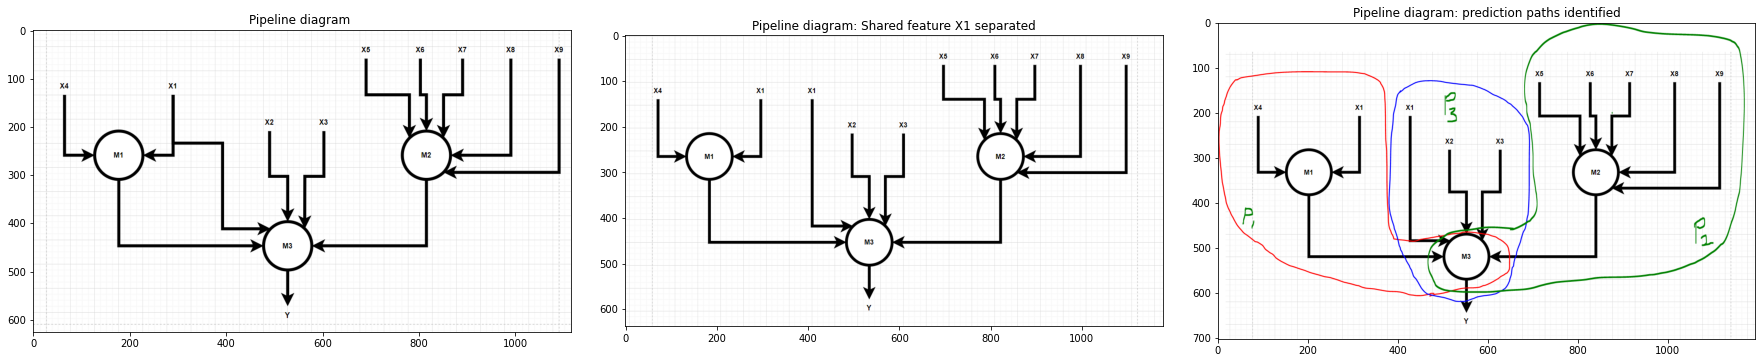

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import ipyplot
%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 25 ,15

# read images
img_A = mpimg.imread('financial_diagram.PNG')
img_B = mpimg.imread('financial_diagram_2.PNG')
img_C = mpimg.imread('financial_diagram_paths.PNG')
#ipyplot.plot_images([img_A,img_B], max_images=20, img_width=150)
# display images
fig, ax = plt.subplots(1,3)
ax[0].imshow(img_A)
ax[1].imshow(img_B)
ax[2].imshow(img_C)
ax[0].set_title("Pipeline diagram ")
ax[1].set_title("Pipeline diagram: Shared feature X1 separated")
ax[2].set_title("Pipeline diagram: prediction paths identified")
#plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.95, hspace=0.7)
plt.tight_layout(pad=2.6, w_pad=2.9, h_pad=2.0)

In [7]:
#pyplot_figure??
from LocalityFocusedLime import LFLimeTabularExplanation

In [8]:
from lime_explainer import LimeTabularExplainerReview
discretize_continuous = True

# initialise the lime explanation evaluator
from LocalityFocusedLime import LFLimeTabularExplanation #as LimeTabularExplainerReview
#LimeTabularExplainerReview = LFLimeTabularExplanation
categorical_idx = {7:np.array(list(feature_names_nob)[:-1])}
categorical_idx.update({0: np.array([0., 1., 2., 3., 4., 5., 6., 7.]),
 1: np.array([0., 1., 2., 3.]),})
lime_sampler =  LFLimeTabularExplanation(raw_train_dataset.values[:,:],
                                    class_names=['y1','y2'],
                                    feature_names=raw_train_dataset.columns[:],
                                    categorical_features=[0,1,7],
                                    discretize_continuous=discretize_continuous,
                                    discretizer='quartile',
                                    sample_around_instance=True,
                                           hybrid_sample=False,
                                    categorical_names=categorical_idx,
                                     random_state=seed_rand,)

In [9]:
# Define the LIME explainer for Model M1 (Nature of business classifier)
m1_predictor = Predictor(m1_classifier,['category','amount'],m1_processor,)
m1_explainer_lime = LimeTabularExplainerReview(nob_raw_data_train.values,
                                    class_names=nob_classes,
                                    feature_names=['category','amount'],
                                    categorical_features=[0],
                                               kernel_width=1.8,
                                               #hybrid_sample=False,
                                    categorical_names={0:np.array(list(feature_names_nob)[:-1])},
                                     discretize_continuous=discretize_continuous,
                                         random_state=seed_rand,)


# Define the explaner for M2 (Frequency of Transaction)
m2_predictor = Predictor(m2_classifier,feature_names_freq,None,None)
m2_explainer_lime = LimeTabularExplainerReview(freq_train_x.values,
                                    class_names=['infrequent', 'rare', 'regular'],
                                    feature_names=['avg_tbt',
                                                   'std_tbt',
                                                   'avg_amt',
                                                   'std_amt',
                                                   't_count'],
                                               categorical_features=[],
                                               kernel_width=1.8,
                                               #hybrid_sample=False,
                                     discretize_continuous=discretize_continuous,
                                    random_state=seed_rand,)


other_processor = lambda x_test: x_test.replace({'nob_risk':nob_idx_labels,'frequency': freq_idx_labels,})
m3_predictor = Predictor(m3_classifier,decision_features,m3_processor,other_processor)

m3_categorical_names_idx = {idx: m3_categorical_names[k] for idx, k in enumerate(decision_features) if k in m3_categorical_names.keys() }

# Build the explainer
m3_explainer_lime = LimeTabularExplainerReview(train_m3.values,
                                    class_names=['y1','y2'],
                                    feature_names=decision_features,
                                          discretize_continuous=discretize_continuous,
                                    categorical_features=[0,1,3,4],
                                               kernel_width=1.8,
                                               #hybrid_sample=False,
                                    #discretizer='quartile',
                                    categorical_names=m3_categorical_names_idx,random_state=seed_rand,)

In [10]:
#Define the pipeline prediction routine

def sub_pipelined(X):
    if X.ndim < 2:
        X = np.reshape(X,(1,-1))
    
    m1_pred = m1_predictor(X[:,m1_features_idx])
    m2_pred = m2_predictor(X[:,m2_features_idx])
    return m1_pred,m2_pred
def pipelinedGetSubPredictions(X,is_proba=True,):
    if X.ndim < 2:
        X = np.reshape(X,(1,-1))
    return sub_pipelined(X) if is_proba else  [t.argmax(-1) for t in sub_pipelined(X)]
def pipelinedPrediction(X,is_proba=True,return_sub=False):
    if return_sub:
        return pipelinedGetSubPredictions(X,is_proba)
    if X.ndim < 2:
        X = np.reshape(X,(1,-1))
    
    m1_pred = m1_predictor(X[:,m1_features_idx]).argmax(-1)
    m2_pred = m2_predictor(X[:,m2_features_idx]).argmax(-1)
    
    submodels_preds= pd.DataFrame(np.stack([m1_pred,m2_pred],axis=-1).astype('int32'),columns=m3_external)
    if return_sub:
        return submodels_preds
    
    x_test_m3 = pd.DataFrame(X[:,m3_features_idx], columns=m3_features_sub)
    
    # Compose the features for the final stage of the pipeline
    x_test_m3= pd.concat([x_test_m3,
                          submodels_preds],axis=1).values
    #print(x_test_m3)
    pred_prob= m3_predictor(x_test_m3)
    
    return pred_prob.argmax(-1) if not is_proba else pred_prob

class BlackBoxPipeline:
    def __init__(self,pipeline_pred_function):
        self.pipelinedPrediction = pipeline_pred_function
    
    def predict(self, X):
        return self.pipelinedPrediction(X,is_proba=False)
    def predict_proba(self,X):
        return self.pipelinedPrediction(X,is_proba=True)
    
    def __call__(self,X,is_proba=True):
        return self.predict_proba(X)
    
    def getSubPredictions(self,X,is_proba=False):
        return self.pipelinedPrediction(X,is_proba=is_proba,return_sub=True)
    

black_box_pipelined = BlackBoxPipeline(pipelinedPrediction)

In [11]:
categorical_idxu = {7:np.array(list(feature_names_nob)[:-1])}
categorical_idxu.update({0: np.array([0., 1., 2., 3., 4., 5., 6., 7.]),
 1: np.array([0., 1., 2., 3.]),})
# Explainer for the whole black-box without considering the internal sub-models
mf_explainer_lime =  LimeTabularExplainerReview(raw_train_dataset.values,
                                    class_names=['y1','y2'],
                                    feature_names=raw_train_dataset.columns,
                                    categorical_features=[0,1,7],
                                          kernel_width=1.8,
                                          discretize_continuous=discretize_continuous,
                                                #hybrid_sample=False,
                                    discretizer='quartile',
                                    categorical_names=categorical_idxu,random_state=seed_rand,)

In [12]:
# Define the prediction paths within the pipeline model
# The path to each sub-model is choosen as the paths of prediction
prediction_paths_simple = {'P1':{'sub_models':{'M1':{'explainer':m1_explainer_lime,
                                              'pred_fn':m1_predictor,
                                              'features':m1_features}}},
                           'P2':{'sub_models':{'M2':{'explainer':m2_explainer_lime,
                                             'pred_fn':  m2_predictor,
                                              'features':m2_features}}},
                           'P3':{'sub_models':{
                               'M3':{'explainer':m3_explainer_lime,
                                             'pred_fn':  m3_predictor,
                                              'features':m3_features_sub+['M1','M2']}}},
                   }


overlap_prediction_paths = {
    'P3':{'sub_models':{
                       'M1':{'explainer':m1_explainer_lime,
                                              'pred_fn':m1_predictor,
                                              'features':m1_features},
                       'M2':{'explainer':m2_explainer_lime,
                                             'pred_fn':  m2_predictor,
                                              'features':m2_features},
                       'M3':{'explainer':m3_explainer_lime,
                                             'pred_fn':  m3_predictor,
                                              'features':m3_features_sub+['M1','M2']}}},
    'P1':{'sub_models':{'M1':{'explainer':m1_explainer_lime,
                                              'pred_fn':m1_predictor,
                                              'features':m1_features}}},
                   'P2':{'sub_models':{'M2':{'explainer':m2_explainer_lime,
                                             'pred_fn':  m2_predictor,
                                              'features':m2_features}}},
                    # Before the prediction on path P3, operations on paths P1 and P2 are first executed
                   
                   }


pipeline_utils = {   # Define the final model in the pipeline
                    'pipeline_pred_fn': partial(pipelinedPrediction,is_proba=True),
                    'pipelined_features':full_features,
                    'pipelined_features_raw':full_raw_features,
                    'decision_model':{'explainer':m3_explainer_lime,
                                      'pred_fn':m3_predictor,
                                              'features':m3_features_sub+['M1','M2']},
    'blind_pipeline':{'pred_fn': partial(pipelinedPrediction,is_proba=True),
                                      'explainer':mf_explainer_lime},
    
                    # Track the features shared across different paths
                    'feature_splits': {'amount_feat':['amount','amount_B']},}
all_features_across_paths = full_features


# Define the flow of information across all the pipeline sub-model
# This will be used to redistibute the contributions of parent nodes across its children
paths_dict_sep= {'P3':{
                   'sub_models':{'M3':m3_features_sub+['M1','M2'],
                                 'M1':m1_features,
                                 'M2':m2_features},},
            'P1':{'sub_models':{'M1':m1_features}},
            'P2':{
                'sub_models':{
                    'M2':m2_features,
                },}
            }

labels=['Fraud','Not Fraud']

In [13]:
import itertools
import re
from collections import Counter
def PathwiseContributionLimeExplanationsCollector(sample,pred_paths,
                                     pipeline_utils,
                                     is_classification=True,
                                     collapse_path_splits=False,
                                     use_mean_across_paths=True,
                                                  num_samples=2000,
                                     epsilon=1e-10,):
    records={}
    
    contribution_records = {}
    
    # Get all the information such as the models and paths from the pred_paths
    p_paths = re.findall('\w\d+',' '.join(list(pred_paths.keys())))
    
    models =[list(pred_paths[p]['sub_models'].keys()) for p in p_paths]
    
    # Retrieve models on paths
    explanation_paths_models = {p:list(pred_paths[p]['sub_models'].keys()) for p in p_paths}
    
    paths_features = {p:[f['features'] for m,f in pred_paths[p]['sub_models'].items()] for p in p_paths}
    
    paths_features = {p:list(itertools.chain(*v)) for p,v in paths_features.items()}
    
    nb_models = len(models)#+1 # +1 for the final model
    
    nb_paths = len(p_paths)
    
    #features = pipeline_utils['pipelined_features']
    full_feature_pipeline = pipeline_utils['pipelined_features']
    features =features_raw = pipeline_utils['pipelined_features_raw']
    
    
    
    feature_explanation_table = pd.DataFrame(np.zeros((len(features_raw)+nb_models+1,
                                                       nb_paths+1)), 
                                                      columns= [f'P{i+1}' for i in range(nb_paths)]+['MF'])
    
    feature_explanation_table.index = features_raw+[f'M{i+1}' for i in range(nb_models)]+['base_v']
    
    
    
    #subs= pipeline_utils[ 'pipeline_pred_fn'](np.array(sample),return_sub=True)
    
    
    
    
    # Compose the feature Dataframe for the sample
   
    sample_df = pd.DataFrame(sample,columns=features_raw)
    pipeline_pred= pipeline_utils['pipeline_pred_fn'](sample).argmax(-1)[0]
    sub_models_prediction =  {'pipeline_prediction': pipeline_pred}
    paths_elements = {}
    already_explained_models =[]
    paths_models = {}
    # Collect the attributions across each path
    for path_name,elements in pred_paths.items():
        sub_models = elements['sub_models']
        previous_model ={}
        paths_models[path_name] = []
        paths_elements[path_name]= set()
        
        for model_name,models_def in sub_models.items():
            #if model_name not in sub_models_prediction.keys():
            input_features = models_def['features']
            model_explainer = models_def['explainer']
            model_pred_fn = models_def['pred_fn']
            prev_models = set(previous_model.keys())
            paths_models[path_name].append(model_name)
            
            
            
            paths_elements[path_name].update(input_features+[model_name])
            
            # Check if the model's input features is not from a previous model on the pipeline
            commons = set([s.lower() for s in sub_models_prediction.keys()]).intersection([d.lower() for d in input_features])
            raw_features = [f for f in input_features if f in features_raw]
            intermediate_output_features =  [f for f in input_features if f not in features]
            if len(commons)<1:
                # Then there is no previous model that this model is connected to
                data_sample = sample_df[input_features].values
            else:
                # If the model is dependent on a previous model
                data_sample = sample_df[raw_features]
                previous_model_preds = pd.DataFrame(np.asarray([[p[0] for k,
                                                                 p in sub_models_prediction.items() if k in intermediate_output_features]]),columns=intermediate_output_features)
                data_sample = pd.concat([data_sample,
                                         previous_model_preds],
                                        axis=1)[input_features].values
            
            # Get the prediction from the model
            pred_label = model_pred_fn(data_sample).argmax(-1)[0] if is_classification else model_pred_fn(data_sample)   
            previous_model[model_name] = pred_label
            sub_models_prediction[model_name] = [pred_label]
            
            
            
           
            #print(path_name,model_explainer.expected_value[pred_label])
            if model_name not in already_explained_models:
                # Explain the prediction decision
                nb_feats= data_sample[0].shape[-1]
                instance_explanation = model_explainer.explain_instance(data_sample[0],
                                                                    model_pred_fn,
                                                                        num_samples=num_samples,
                                                                        num_features=nb_feats,
                                                                        #locality_focused=False,
                                                                    labels=[pred_label])
                
                records[model_name+'_explainer'] = instance_explanation 
                records[f'intercept_{model_name}']=instance_explanation.intercept[pred_label]
                #feature_explanation_table.loc['base_v',[path_name]] = instance_explanation.intercept[pred_label]
                already_explained_models.append(model_name)
                #instance_explanation.show_in_notebook()
                #plt.pause(0.0002)
                m1_attributions = dict(list(instance_explanation.local_exp.values())[0])
                #print(instance_explanation.local_features[pred_label])
                for idx, f in enumerate(input_features):
                    att = m1_attributions[idx]
                    #m1_attributions_array[0,idx] = att
                    feature_explanation_table.loc[f,[path_name]]  =  att
                    
                    if f not in contribution_records.keys():
                        contribution_records[f]=0
                    
                    
                    for p in p_paths:
                        
                        if p !=path_name:
                            #print(f,p,explanation_paths_models[p])
                            if f in paths_features[p] or f in explanation_paths_models[p]:
                                #contribution_records[f]+=1
                                feature_explanation_table.loc[f,[p]]  =  att
                        else:
                            if f in explanation_paths_models[p]:
                                feature_explanation_table.loc[f,[p]]  =  att
            
                
    
    
    # Features contributing to all the paths will generally have higher cummulative contribution, we can penalize this by return 
    # the mean contribution across all the paths
    xx = dict(Counter(list(itertools.chain(*paths_elements.values()))))
    xx['base_v']=1
    elements_counts = pd.Series(xx)+ epsilon
    records['nb_elements_path'] = elements_counts
    
    # Simplify the feature attribution dataframe 
    attributions=feature_explanation_table.iloc[:-1,:][list(paths_elements.keys())].sum(axis=1)
    attributions = attributions.loc[:,].divide(elements_counts.loc[attributions.index[:]])
    attributions = attributions.to_frame()
    attributions.columns =['Attributions']
    
    
    return  feature_explanation_table,attributions,sub_models_prediction,records#,Counter(elements)
def parentAttributionDistribution(parent_attribution,sub_attributions,method='uniform'):
    # get the n
    attributions = sub_attributions
    n= len(attributions)
    #print(n)
    if method=='uniform':
        # Assumption that each feature contributed equally resulting in the attribution assigned to the parent model
        elem = np.repeat((parent_attribution/n),n)
        elem = np.reshape(elem,(-1,1))
        return elem#*attributions
    if method=='zz_uniform':
        # Assumption that each feature contributed equally resulting in the attribution assigned to the parent model
        elem = np.repeat((parent_attribution/n),n)
        elem = np.reshape(elem,(-1,1))
        return elem+attributions
    if method=='absolute':
        return (parent_attribution*np.abs(attributions)/np.abs(attributions).sum()) #+ attributions
    if method=='squared':
        return ((attributions**2/(attributions**2).sum()) * parent_attribution) #+attributions
    
    
    if method=='nw':
        w= (attributions/(attributions).sum())
        #print(w)
        return w * parent_attribution
    if method =='raw_weights':
        z= attributions/(attributions).sum()*parent_attribution
        return z
    if method =='ad_raw_weights':
        z= attributions/(attributions).sum()*parent_attribution  + attributions
        return z

def RedistributeLocalContributionWithIntercept(pipeline_utils,
                                 label,
                                 attributions,
                                               intercepts,
                                 predictors,
                                 paths_information,
                                 method='absolute',
                                 is_shapely=False,
                                 verbose=True,
                                collapse_path_splits=False,
                                ):
    zzb=attributions.copy(deep=True)
    index_to_drop=['base_v'] if is_shapely else []
    modified_intercepts = {}
    for p,data in paths_information.items():
        for m,feats in data['sub_models'].items():
            f= (attributions.loc[feats]**2).sum().values + 1e-10
            index_to_drop.append(m)
            if attributions.loc[m].values[0] !=0:
                
                int_cept= intercepts[f'intercept_{m}'] if f'intercept_{m}' not in modified_intercepts else modified_intercepts[f'intercept_{m}']
                int_cept = np.array([int_cept]).reshape(1,-1)
                #print(attributions.loc[feats].values.shape)
                att= parentAttributionDistribution(attributions.loc[m].values,
                                                   np.vstack([int_cept,attributions.loc[feats].values]),
                                                   method=method)
                zzb.loc[feats]= att[1:]
                modified_intercepts[f'intercept_{m}']= att[0]
                #((attributions.loc[feats]**2)/f)*attributions.loc[m] #+ attributions.loc[feats])
            else:
                zzb.loc[feats]= attributions.loc[feats]
    zzb.drop(index=index_to_drop,inplace=True)
    
    if verbose:
        att=list(zzb.loc[predictors].to_records())
        att= sorted(att,key=lambda x:round(abs(x[1]),3))
        pyplot_figure(att,f'Y = {label}');
    return zzb,modified_intercepts

seed_everything(seed_rand)

def limeExplainPipeline(sample,labels,
                        prediction_paths,pipeline_utils,
                        redistribution_paths,
                        num_samples=2000,
                        redistribution_method='raw_weights',
                       
                       ):
    
    (feature_explanation_tables,raw_attributions,sub_models_predictions,
     explanations_recordss)=PathwiseContributionLimeExplanationsCollector(sample,prediction_paths,
                                                                          pipeline_utils,num_samples=num_samples,
                                                                          collapse_path_splits=False,
                                                                          use_mean_across_paths=False)
    pred_label = labels[sub_models_predictions['pipeline_prediction']]
    predictors_ = pipeline_utils['pipelined_features']
    attribution_distributed =  RedistributeLocalContributions(
                                                              pipeline_utils,
                                          pred_label,
                                          raw_attributions,
                                          predictors_,
                                          redistribution_paths,
                                          method=redistribution_method,
                                              verbose=True,
                                          is_shapely=False,
                                          collapse_path_splits=False)
    
    return raw_attributions,attribution_distributed,sub_models_predictions,explanations_recordss
def limeExplainPipelineMultiMethods(sample,labels,
                        prediction_paths,pipeline_utils,
                        redistribution_paths,
                        num_samples=2000,
                        redistribution_methods=['raw_weights','ad_raw_weights','absolute','squared'],
                       verbose=False,
                       ):
    
    (feature_explanation_tables,raw_attributions,sub_models_predictions,explanations_recordss)=PathwiseContributionLimeExplanationsCollector(sample,prediction_paths,
                                                                                                                                             pipeline_utils,num_samples=num_samples,collapse_path_splits=False,use_mean_across_paths=False)
    pred_label = labels[sub_models_predictions['pipeline_prediction']]
    predictors_ = pipeline_utils['pipelined_features']
    resul={}
    
    modified_intercepts ={}
    # get all the intercepts
    intercepts ={}
    for k,v in explanations_recordss.items():
        if 'intercept_' in k:
            intercepts[k]= v
    for method in redistribution_methods:
        if verbose:
            print(f'Method: {method}')
        attribution_distributed,mr =  RedistributeLocalContributionWithIntercept(pipeline_utils,
                                          pred_label,
                                          raw_attributions,
                                                                              intercepts,
                                          predictors_,
                                          redistribution_paths,
                                          method=method,
                                              verbose=verbose,
                                          is_shapely=False,
                                          collapse_path_splits=False)
        #print(predictors_)
        resul[method]=attribution_distributed.loc[predictors_]
        modified_intercepts[method]= mr
        plt.pause(0.00001)
    
    return raw_attributions,resul,sub_models_predictions,explanations_recordss,modified_intercepts


Global seed set to 765


In [14]:
tidxs=152
#479
#153

sample= raw_test_dataset.values[tidxs]
sample = np.asarray([sample])

In [15]:
running_sample = pd.read_csv('running_test_case.csv',index_col=0)[raw_columns[:-1]]
running_sample['amount_B']= running_sample.amount
running_sample['category'] = list(feature_names_nob).index(running_sample.category.values[0])

In [16]:
running_sample

,age,gender,avg_tbt,std_tbt,avg_amt,std_amt,t_count,category,amount,amount_B
0,3.0,1.0,1.265306,0.581185,29.378889,17.849542,0.838983,12,0.267,0.267


Global seed set to 765


Method: raw_weights


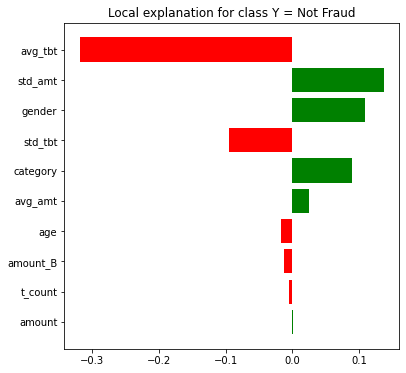

Method: ad_raw_weights


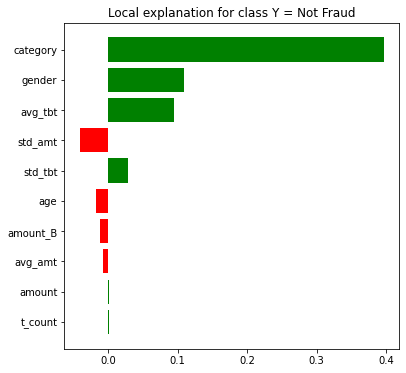

Method: absolute


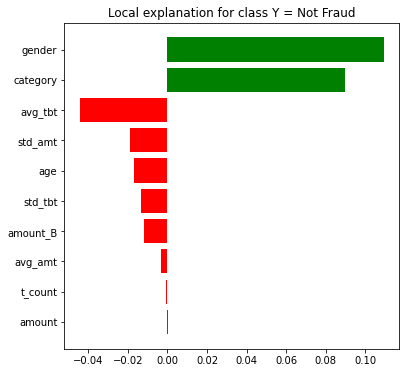

Method: squared


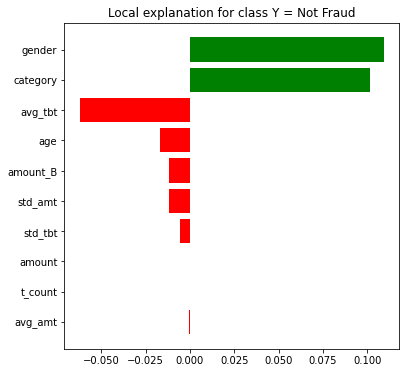

In [17]:
seed_everything(seed_rand)
raw_attributions,attribution_distributed,sub_models_predictions,explanations_recordss,modified_intercepts=limeExplainPipelineMultiMethods(running_sample.values,labels,prediction_paths_simple,pipeline_utils,paths_dict_sep,verbose=True)
pred = sub_models_predictions['pipeline_prediction']

In [18]:
m1_attributions = dict(list(explanations_recordss['M3_explainer'].local_exp.values())[0])

In [19]:
explanations_recordss['M3_explainer'].local_models[1].coef_

array([ 0.10951406, -0.09745053,  0.10574052, -0.01702009, -0.01171425])

In [20]:
m1_attributions

{1: 0.10951405825934846,
 3: 0.10574051629085823,
 4: -0.09745053082092968,
 0: -0.01702008685181619,
 2: -0.011714247878713186}

In [191]:
explanations_recordss['intercept_M2']

0.2703418815022506

In [192]:
modified_intercepts

{'raw_weights': {'intercept_M1': array([0.01558053]),
  'intercept_M2': array([0.16003604])},
 'ad_raw_weights': {'intercept_M1': array([0.62979134]),
  'intercept_M2': array([0.13849063])},
 'absolute': {'intercept_M1': array([0.01558053]),
  'intercept_M2': array([-0.0163311])},
 'squared': {'intercept_M1': array([0.00398551]),
  'intercept_M2': array([-0.01765428])}}

In [247]:
attribution_distributed['absolute'].sum() + np.array(list(modified_intercepts['absolute'].values())).sum()  +  explanations_recordss['intercept_M3']

Attributions    0.5729
dtype: float64

In [248]:
attribution_distributed['squared'].sum() + np.array(list(modified_intercepts['squared'].values())).sum()  +  explanations_recordss['intercept_M3']

Attributions    0.5729
dtype: float64

In [249]:
cv=explanations_recordss['M3_explainer'].sampled_data[0][explanations_recordss['M3_explainer'].local_features[pred]].reshape(1,-1)

In [250]:
zcv=explanations_recordss['M3_explainer'].sampled_data[0].reshape(1,-1)

In [251]:
attribution_distributed['squared'].values.reshape(-1)

array([-8.68850035e-03,  1.02364377e-01, -6.62877872e-02, -1.39999714e-03,
       -8.03292807e-04, -1.34041750e-02, -1.19177007e-06,  8.20043764e-02,
        9.82685113e-07, -5.78224287e-03])

In [252]:
zcv

array([[1., 1., 1., 1., 1.]])

In [253]:
explanations_recordss['M3_explainer'].local_models[1].predict(cv)

array([0.57290022])

In [238]:
np.array(list(dict(explanations_recordss['M3_explainer'].local_exp[1]).values())).sum() +  explanations_recordss['intercept_M3']

0.5754904359987312

In [21]:
## Blind Explainer
exp_blind_level = mf_explainer_lime.explain_instance(running_sample.values[0],
                                                     black_box_pipelined, 
                                                     #locality_focused=False,
                                                     num_samples=2000,labels=[pred])
exp_blind_level.show_in_notebook()

In [22]:
explanations_recordss['M3_explainer'].show_in_notebook()

In [23]:
def reformatPredictor(examples):
    return examples
    e_l = examples[0][:,[-1]]
    exm = np.hstack([examples[0],e_l])
    
    e_l = examples[1][:,[-1]]
    exm_inverse = np.hstack([examples[1],e_l])
    return exm,exm_inverse


In [24]:
class DummyExplanations():
    def __init__(self,mean_,scale_,):
        self.local_models={}
        self.local_features ={}
        self.mean_ =mean_
        self.scale_ = scale_
class DistributedEvalSurrogate():
    def __init__(self,
                 #sub_models,
                 sub_models_feature_idx,
                 decision_model,):
        self.decision_model = decision_model
        self.sub_models_feature_idx = sub_models_feature_idx
    def predict(self,X,is_same_factor):
        sub_predictions= []
        X = np.copy(X)
        for idx, feature_idx in enumerate(self.sub_models_feature_idx):
            #print(is_same_factor[:,idx].shape,X[:,feature_idx].shape)
            for i in feature_idx:
                X[:,i]=is_same_factor[:,idx]
        
        return self.decision_model.predict(X)    
            
        
class PipelineLocalSurrogate:
    def __init__(self,sub_models,
                 sub_models_feature_idx,
                 sub_model_explanation_features,
                 sub_model_decision_thresholds,
                 sub_models_labels,
                 decision_model,
                 decision_model_explanation_features,
                 decision_model_sub_feature_idx):
        self.sub_models_labels = sub_models_labels
        self.decision_model = decision_model
        self.decision_model_sub_feature_idx = decision_model_sub_feature_idx
        self.sub_models = sub_models
        self.sub_models_feature_idx = sub_models_feature_idx
        self.sub_model_explanation_features = sub_model_explanation_features
        self.sub_model_decision_thresholds= sub_model_decision_thresholds
        self.decision_model_explanation_features = decision_model_explanation_features
        
    def predict_subs(self,X,is_same_factor):
        xx= X[:,self.decision_model_sub_feature_idx ]
        if is_same_factor.shape[-1]>0:
            xx=np.hstack([xx,is_same_factor])
        xx= xx[:,self.decision_model_explanation_features]
        return self.decision_model.predict(xx)
    
    def predict(self,X):
        sub_predictions= []
        for sub_model, feature_idx,exp_feat,dt in zip(self.sub_models,self.sub_models_feature_idx,
                                                      self.sub_model_explanation_features,
                                                      self.sub_model_decision_thresholds):
            Xf= X[:,feature_idx][:,exp_feat]
            pred_sub = np.int32(sub_model.predict(Xf)>dt)
            sub_predictions.append(pred_sub.reshape(-1,1))
            #np.int32(zz>0.5)
        
        if len(sub_predictions)>0:
            sub_predictions= np.hstack(sub_predictions)
        #print(sub_predictions)
        # Compose the features for the decision model M3
        
        xx= X[:,self.decision_model_sub_feature_idx ]
        if len(sub_predictions)>0:
            xx=np.hstack([xx,sub_predictions])
        xx= xx[:,self.decision_model_explanation_features]  
        return self.decision_model.predict(xx)


In [25]:
import copy
def evaluatePerformance(test_cases,  evaluation_radius=0.68,
                        selection_radius= 10.56,
                        evaluation_sample_size= 800,
                        categoricalise_all=False):
    def fidelity(bmodel_pred, local_pred):
        return 1/( localApproximationError(bmodel_pred, local_pred)+1)
    def localApproximationError(bmodel_pred, local_pred):
        return abs(bmodel_pred-local_pred)
    
    def _score(bmodel_pred, local_pred):
        mse= mean_squared_error(bmodel_pred, local_pred)
        lae= localApproximationError(bmodel_pred, local_pred).mean()
        lf= 1/(1. + lae)
        return mse,lae,lf
    
    score_records = {'MSE':{'ABS':[],'SQ':[],
                            'RW':[],'SUB':[],'BLD':[]},
                    'LAE':{'ABS':[],'SQ':[],
                            'RW':[],'SUB':[],'BLD':[]},
                     'LF':{'ABS':[],'SQ':[],
                            'RW':[],'SUB':[],'BLD':[]}
                    }
    lime_sampler.categoricalise_all=categoricalise_all
    for idx,sample in tqdm.tqdm(enumerate(test_cases)):
        sample_= sample = np.asarray([sample])
        # Fit the surrogate models for the different sub-models within the pipeline, then perform the explanation
        # distribution
        
        m1_th,m2_th= sub_pipelined(sample_)
        nb_feats = sample_.shape[-1]
        #print(m1_th,m2_th)
        
        (araw_attributions,aattribution_distributed,
         asub_models_predictions,aexplanations_recordss,amodified_intercepts)=limeExplainPipelineMultiMethods(sample_,
                                                                                                              labels,
                                                                                       prediction_paths_simple,
                                                                                       pipeline_utils,
                                                                                       paths_dict_sep,
                                                                                       num_samples=2000,
                                                                                                              verbose=False)
        pred = asub_models_predictions['pipeline_prediction']
        
        # fit the blind-level explainer 
        aexp_blind_level = mf_explainer_lime.explain_instance(sample_[0],
                                                             black_box_pipelined,
                                                             # locality_focused=False,
                                                             num_samples=2000,
                                                              num_features=nb_feats,
                                                             labels=[pred])
        
        




        # Initialise new regressor with the attributions computed
        # Set-up an object to hold the explanation
        amodel_regressor_ab = Ridge(alpha=1, fit_intercept=True,
                                            random_state=m3_explainer_lime.random_state)
        amodel_regressor_ab.coef_ = aattribution_distributed['absolute'].values.reshape(-1)
        amodel_regressor_ab.intercept_ = aexplanations_recordss['intercept_M3'] + (np.array(list(amodified_intercepts['absolute'].values()))).sum()
        
        _amodel_regressor_ab = DistributedEvalSurrogate([m1_features_idx,m2_features_idx],amodel_regressor_ab,)
        
        adummy_exp_ab = DummyExplanations(mf_explainer_lime.scaler.mean_,
                                                   mf_explainer_lime.scaler.scale_)
        adummy_exp_ab.local_models[pred]= amodel_regressor_ab
        adummy_exp_ab.local_features[pred] =  np.arange(len(aattribution_distributed['absolute'].index))



        amodel_regressor_sq= Ridge(alpha=1, fit_intercept=True,random_state=m3_explainer_lime.random_state)
        amodel_regressor_sq.coef_ = aattribution_distributed['squared'].values.reshape(-1)
        amodel_regressor_sq.intercept_ = aexplanations_recordss['intercept_M3'] + (np.array(list(amodified_intercepts['squared'].values()))).sum()
        _amodel_regressor_sq = DistributedEvalSurrogate([m1_features_idx,m2_features_idx],amodel_regressor_sq,)
        
        adummy_exp_sq = DummyExplanations(mf_explainer_lime.scaler.mean_,
                                                   mf_explainer_lime.scaler.scale_)
        adummy_exp_sq.local_models[pred]= amodel_regressor_sq
        adummy_exp_sq.local_features[pred] =  np.arange(len(aattribution_distributed['squared'].index))


        amodel_regressor_rw= Ridge(alpha=1, fit_intercept=True,
                                            random_state=m3_explainer_lime.random_state)
        amodel_regressor_rw.coef_ = aattribution_distributed['raw_weights'].values.reshape(-1)
        amodel_regressor_rw.intercept_ = aexplanations_recordss['intercept_M3'] + (np.array(list(amodified_intercepts['raw_weights'].values()))).sum()
        _amodel_regressor_rw = DistributedEvalSurrogate([m1_features_idx,m2_features_idx],amodel_regressor_rw,)
        
        adummy_exp_rw = DummyExplanations(mf_explainer_lime.scaler.mean_,
                                                   mf_explainer_lime.scaler.scale_)
        adummy_exp_rw.local_models[pred]= amodel_regressor_rw
        adummy_exp_rw.local_features[pred] =  np.arange(len(aattribution_distributed['raw_weights'].index))


        # Set up the local surrogate and explainer for the blind-level explanation
        amodel_regressor_blind =aexp_blind_level.local_models[pred]
        adummy_exp_blind = DummyExplanations(mf_explainer_lime.scaler.mean_,
                                                   mf_explainer_lime.scaler.scale_)
        used_features =aexp_blind_level.local_features[pred]
        adummy_exp_rw.local_models[pred] = amodel_regressor_blind
        adummy_exp_rw.local_features[pred] =  used_features


        # Set up the pipelined explainer for the sub-modelwise method
        # Collect all the neccessary information about all the surrogate models fitted at each step
        m1_pred = asub_models_predictions['M1'][0]
        m2_pred = asub_models_predictions['M2'][0]
        m3_pred = asub_models_predictions['M3'][0]
        
        m1_used_features = aexplanations_recordss['M1_explainer'].local_features[m1_pred]
        m2_used_features = aexplanations_recordss['M2_explainer'].local_features[m2_pred]
        m3_used_features = aexplanations_recordss['M3_explainer'].local_features[m3_pred]
        apipeline_surrogate = PipelineLocalSurrogate(sub_models=[aexplanations_recordss['M1_explainer'].local_models[m1_pred],
                                                               aexplanations_recordss['M2_explainer'].local_models[m2_pred]
                                                               ],
                         sub_models_feature_idx=[m1_features_idx,m2_features_idx],
                         sub_model_explanation_features=[m1_used_features,m2_used_features],
                         sub_model_decision_thresholds=[0.5,0.5],#[m1_th[m1_pred],m2_th[m2_pred]],
                         sub_models_labels=[m1_pred,m2_pred],
                                                    decision_model_explanation_features=m3_used_features,
                         decision_model=aexplanations_recordss['M3_explainer'].local_models[m3_pred],
                         decision_model_sub_feature_idx=m3_sub_feature_idx)
        
        ablind_surrogate = PipelineLocalSurrogate(sub_models=[
                                                       ],
                 sub_models_feature_idx=[],
                 sub_model_explanation_features=[],
                 sub_model_decision_thresholds=[],
                 sub_models_labels=[],
                 decision_model_explanation_features=aexp_blind_level.local_features[pred],
                 decision_model=amodel_regressor_blind,
                 decision_model_sub_feature_idx=np.arange(len(raw_columns)))
        
        # generate evaluation samples per the radius
        #alocal_neighbourhood = reformatPredictor(lime_sampler.generateLocalSamples(sample_[:,:],num_samples=evaluation_sample_size,radius=evaluation_radius))
        
        alocal_neighbourhood1 = reformatPredictor(lime_sampler.generateLocalSamples(sample_[:,:],
                                                                                  num_samples=evaluation_sample_size,
                                                                                  radius=evaluation_radius,selection_radius=selection_radius
                                                                                          ))
        #
        
        #data1= np.vstack([alocal_neighbourhood1[0],alocal_neighbourhood2[0]])
        #data2= np.vstack([alocal_neighbourhood1[1],alocal_neighbourhood2[1]])
        
        #data1[0] = np.ones((len(raw_columns)))
        #data2[0] = sample_[0]
        
        alocal_neighbourhood = alocal_neighbourhood1#[data1,data2]
        
        
        # get the prediction from the pipeline architecture
        yg= black_box_pipelined.predict_proba(alocal_neighbourhood[-1])[:,pred]
        
        yg_sub_labels = np.array(black_box_pipelined.getSubPredictions(alocal_neighbourhood[-1],
                                                                       is_proba=False)).reshape(-1,2)
        sample_sub_labels = np.array(black_box_pipelined.getSubPredictions(sample_.reshape(1,-1),
                                                                           is_proba=False)).reshape(1,2)
        
        #print(alocal_neighbourhood[-1].shape)
        
        is_same = np.int32(sample_sub_labels==yg_sub_labels)
        
        #print(is_same.shape)
        
        
        
        # get the prediction from all the surrogate models
        
        ya= _amodel_regressor_ab.predict(alocal_neighbourhood[0],is_same)
        abs_score = _score(yg,ya) #mse,lae,lf
        score_records['MSE']['ABS'].append(abs_score[0])
        score_records['LAE']['ABS'].append(abs_score[1])
        score_records['LF']['ABS'].append(abs_score[2])
        
        ys= _amodel_regressor_sq.predict(alocal_neighbourhood[0],is_same)
        sq_score = _score(yg,ys)
        score_records['MSE']['SQ'].append(sq_score[0])
        score_records['LAE']['SQ'].append(sq_score[1])
        score_records['LF']['SQ'].append(sq_score[2])
        
        yr= _amodel_regressor_rw.predict(alocal_neighbourhood[0],is_same)
        rw_score = _score(yg,yr)
        score_records['MSE']['RW'].append(rw_score[0])
        score_records['LAE']['RW'].append(rw_score[1])
        score_records['LF']['RW'].append(rw_score[2])
        
        yss =apipeline_surrogate.predict_subs(alocal_neighbourhood[0],is_same)
        subs_score = _score(yg,yss)
        score_records['MSE']['SUB'].append(subs_score[0])
        score_records['LAE']['SUB'].append(subs_score[1])
        score_records['LF']['SUB'].append(subs_score[2])
        
        ybl= ablind_surrogate.predict(alocal_neighbourhood[0])
        bl_score = _score(yg,ybl)
        score_records['MSE']['BLD'].append(bl_score[0])
        score_records['LAE']['BLD'].append(bl_score[1])
        score_records['LF']['BLD'].append(bl_score[2])
        
        #print(score_records)
        
    raw_scores = copy.deepcopy(score_records)
    for metric,elements in score_records.items():
        for method,values in elements.items():
            #print(metric,method,values)
            score_records[metric][method]= np.array(values).mean()
    return score_records,raw_scores   

In [26]:
import tqdm
eval_sample = raw_test_dataset.sample(600)
raw_eval_sample = eval_sample.values

In [80]:
raw_eval_sample[interest_points]

array([[1.00000000e+00, 1.00000000e+00, 3.25641026e+00, 8.83964830e+00,
        3.10827500e+01, 2.20790613e+01, 2.36686391e-01, 1.20000000e+01,
        2.23000000e-01, 2.23000000e-01],
       [5.00000000e+00, 1.00000000e+00, 1.13636364e+01, 5.27899314e+00,
        2.17316667e+01, 2.09906006e+01, 6.85714286e-02, 3.00000000e+00,
        1.90000000e-02, 1.90000000e-02],
       [4.00000000e+00, 1.00000000e+00, 2.60000000e+01, 0.00000000e+00,
        4.56015000e+02, 2.13055000e+02, 1.24223602e-02, 4.00000000e+00,
        1.00000000e+00, 1.00000000e+00],
       [2.00000000e+00, 1.00000000e+00, 1.14166667e+01, 2.18878137e+01,
        2.89915385e+01, 1.77309932e+01, 9.02777778e-02, 1.20000000e+01,
        2.70000000e-02, 2.70000000e-02],
       [2.00000000e+00, 1.00000000e+00, 5.34482759e+00, 6.88464489e+00,
        3.67967000e+02, 2.73984784e+02, 2.38095238e-01, 1.00000000e+01,
        1.23000000e-01, 1.23000000e-01],
       [5.00000000e+00, 2.00000000e+00, 1.49166667e+00, 2.58197545e+00,
   

In [231]:
#xxy=lime_sampler.generateLocalSamples(raw_eval_sample[4],num_samples=1500,radius=0.8,selection_radius=15.6)

In [232]:
xxy[0][0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [213]:
#eval_sample

In [27]:
score_hold,raw_scores=evaluatePerformance(raw_eval_sample,evaluation_radius=0.8,selection_radius=8.6,evaluation_sample_size=1000,categoricalise_all=True)

600it [30:35,  3.06s/it]


In [31]:
# Identify the test cases that each method performed well or poor

In [64]:
#np.argsort(raw_scores['LF']['RW'],)

In [76]:
summary = {}
scores_achieved = {}
interest_points = []
for method,score in raw_scores['LF'].items():
    sorts = np.argsort(score)
    summary[method] = [sorts[-1],sorts[0]]
    scores_achieved[method] = [score[sorts[-1]],score[sorts[0]]]
    interest_points.extend([sorts[-1],sorts[0]])

interest_points = list(set(interest_points))

In [77]:
interest_points_ = eval_sample.iloc[interest_points,:]

In [96]:
interest_points_['idx'] = interest_points
interest_points_['y_label'] = test_y[interest_points]
interest_points_['pred_label'] = black_box_pipelined.predict(raw_eval_sample[interest_points])

In [98]:
summary

{'ABS': [570, 61],
 'SQ': [80, 61],
 'RW': [570, 479],
 'SUB': [284, 530],
 'BLD': [80, 195]}

In [97]:
interest_points_

,age,gender,avg_tbt,std_tbt,avg_amt,std_amt,t_count,category,amount,amount_B,idx,y_label,pred_label
2102,1.0,1.0,3.256410,8.839648,31.082750,22.079061,0.236686,12.0,0.223,0.223,195,0,0
363,5.0,1.0,11.363636,5.278993,21.731667,20.990601,0.068571,3.0,0.019,0.019,80,0,1
1851,4.0,1.0,26.000000,0.000000,456.015000,213.055000,0.012422,4.0,1.000,1.000,530,1,1
1347,2.0,1.0,11.416667,21.887814,28.991538,17.730993,0.090278,12.0,0.027,0.027,570,0,1
1750,2.0,1.0,5.344828,6.884645,367.967000,273.984784,0.238095,10.0,0.123,0.123,284,0,1
608,5.0,2.0,1.491667,2.581975,27.316777,17.022115,0.715976,12.0,0.949,0.949,61,1,0
1916,4.0,2.0,1.192308,0.461538,26.872857,16.232649,0.570652,12.0,0.760,0.760,479,0,1


In [81]:
raw_eval_sample[interest_points][-1]

array([ 4.        ,  2.        ,  1.19230769,  0.46153846, 26.87285714,
       16.23264886,  0.57065217, 12.        ,  0.76      ,  0.76      ])

In [90]:
predf = black_box_pipelined.predict(raw_eval_sample[interest_points])

In [91]:
predf

array([0, 1, 1, 1, 1, 0, 1], dtype=int64)

In [95]:
test_y[interest_points]

array([0, 0, 1, 0, 0, 1, 0])

In [74]:
scores_achieved

{'ABS': [0.9369477740367477, 0.7888177154966801],
 'SQ': [0.9494557863128954, 0.7717542944978982],
 'RW': [0.9552519894889098, 0.06565220588975447],
 'SUB': [0.931597714015239, 0.7955135580044328],
 'BLD': [0.912176309862752, 0.7568910359775983]}

In [84]:
import pickle as pk

In [89]:
pk.dump([scores_achieved,summary,interest_points,],open('best_bad_scores.dat','wb'))

In [82]:
interest_points_.to_csv('interest_points.csv')

In [54]:
raw_scores['LAE']['RW'].index(max(raw_scores['LAE']['RW']))

479

In [51]:
raw_scores['LAE']['RW'][570]

0.046844195043270045

In [28]:
score_hold

{'MSE': {'ABS': 0.045290846607469175,
  'SQ': 0.04688922655744932,
  'RW': 0.8791162910393628,
  'SUB': 0.049546505146787205,
  'BLD': 0.04523655350073377},
 'LAE': {'ABS': 0.16005113955821867,
  'SQ': 0.16192490313983166,
  'RW': 0.22919606688463934,
  'SUB': 0.16830790914172622,
  'BLD': 0.18307796835959558},
 'LF': {'ABS': 0.8629877702441832,
  'SQ': 0.8617204260096553,
  'RW': 0.8443508462244502,
  'SUB': 0.8568252179637315,
  'BLD': 0.8459788078980817}}

In [301]:
score_hold

{'MSE': {'ABS': 0.044566121668040186,
  'SQ': 0.046020494302155456,
  'RW': 1.31157142558591,
  'SUB': 0.048865635866429225,
  'BLD': 0.04575515770832979},
 'LAE': {'ABS': 0.15870607350812804,
  'SQ': 0.16036886401925157,
  'RW': 0.2194168369062527,
  'SUB': 0.16691438751353185,
  'BLD': 0.18427599137998796},
 'LF': {'ABS': 0.8639713912979206,
  'SQ': 0.862848513823346,
  'RW': 0.8499627093989092,
  'SUB': 0.8578436227016023,
  'BLD': 0.8451785452943814}}

In [305]:
score_holdp,raw_scoresp=evaluatePerformance(raw_eval_sample,evaluation_radius=2.8,selection_radius=8.6,evaluation_sample_size=1000,categoricalise_all=True)

600it [36:20,  3.63s/it]


In [306]:
score_holdp

{'MSE': {'ABS': 0.059707925285836246,
  'SQ': 0.06254751499781726,
  'RW': 0.275221738828378,
  'SUB': 0.06322232410638179,
  'BLD': 0.04892927894721797},
 'LAE': {'ABS': 0.19430294702388745,
  'SQ': 0.19776077529323074,
  'RW': 0.22531697011875396,
  'SUB': 0.19966202871886218,
  'BLD': 0.19240383127303962},
 'LF': {'ABS': 0.8381419371544913,
  'SQ': 0.836004885555004,
  'RW': 0.827399270454657,
  'SUB': 0.8342096699881171,
  'BLD': 0.8388017054565471}}

In [307]:
json.dump(raw_scoresp,open('financial_fraud_score_pipedd2.csv','w'))

In [ ]:
1/(0.31+1)

In [99]:
#raw_scores

In [30]:
import json
json.dump(raw_scores,open('financial_fraud_score_pipedd_n2.csv','w'))

<AxesSubplot:>

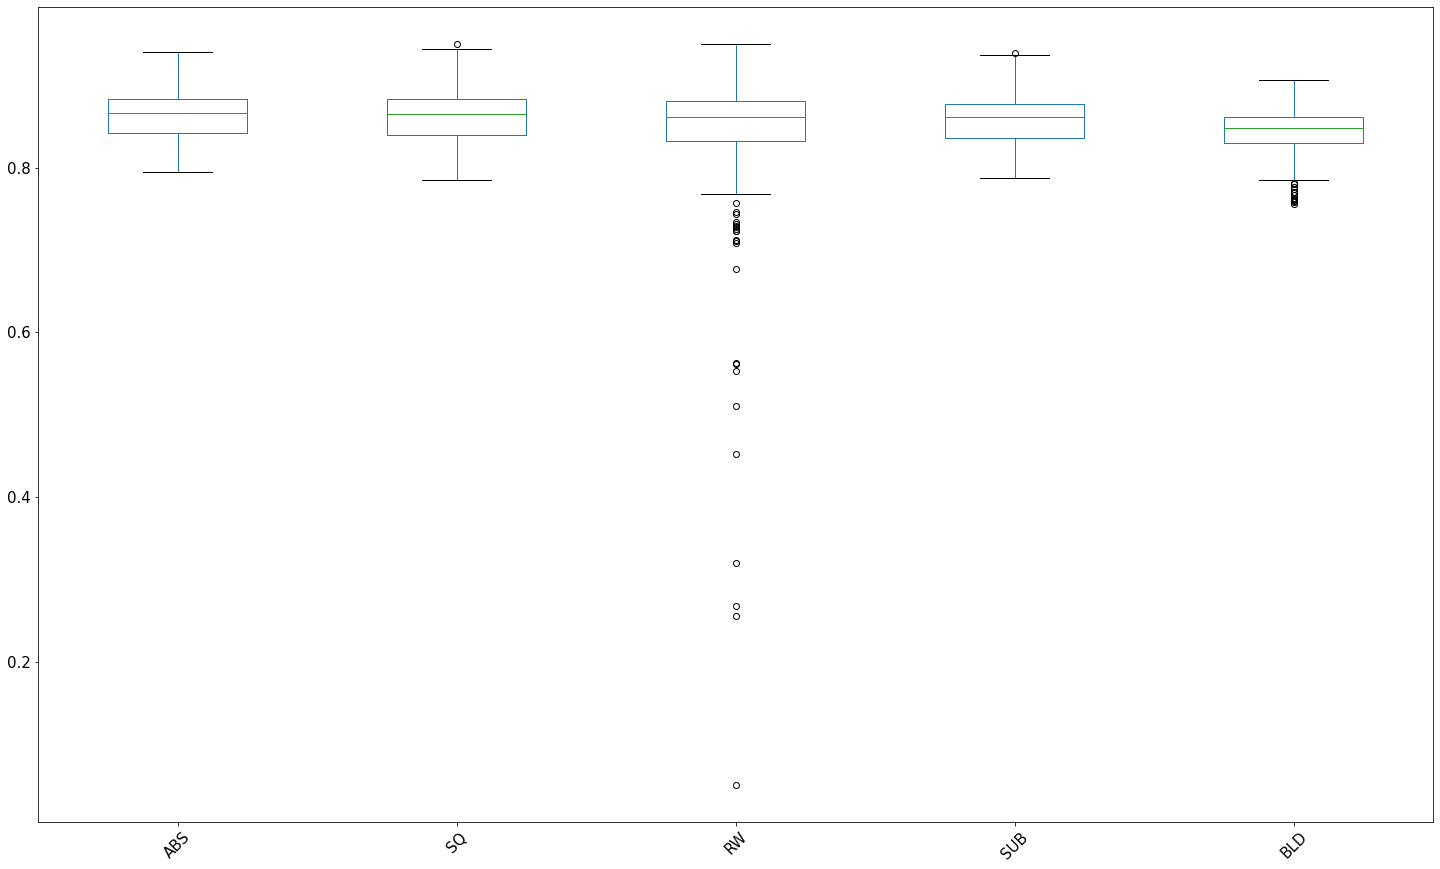

In [302]:
pd.DataFrame(raw_scores['LF'],).boxplot(grid=False, rot=45, fontsize=15)  

In [296]:
zb=pd.DataFrame(raw_scores['LF'],)
zb.describe()

In [297]:
zb.describe()

,ABS,SQ,RW,SUB,BLD
count,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.875277,0.874390,0.869591,0.862115,0.843771
std,0.014998,0.012382,0.011464,0.026963,0.046649
min,0.864672,0.865635,0.861485,0.843049,0.810785
25%,0.869975,0.870013,0.865538,0.852582,0.827278
50%,0.875277,0.874390,0.869591,0.862115,0.843771
75%,0.880580,0.878768,0.873644,0.871648,0.860264
max,0.885883,0.883146,0.877698,0.881181,0.876757


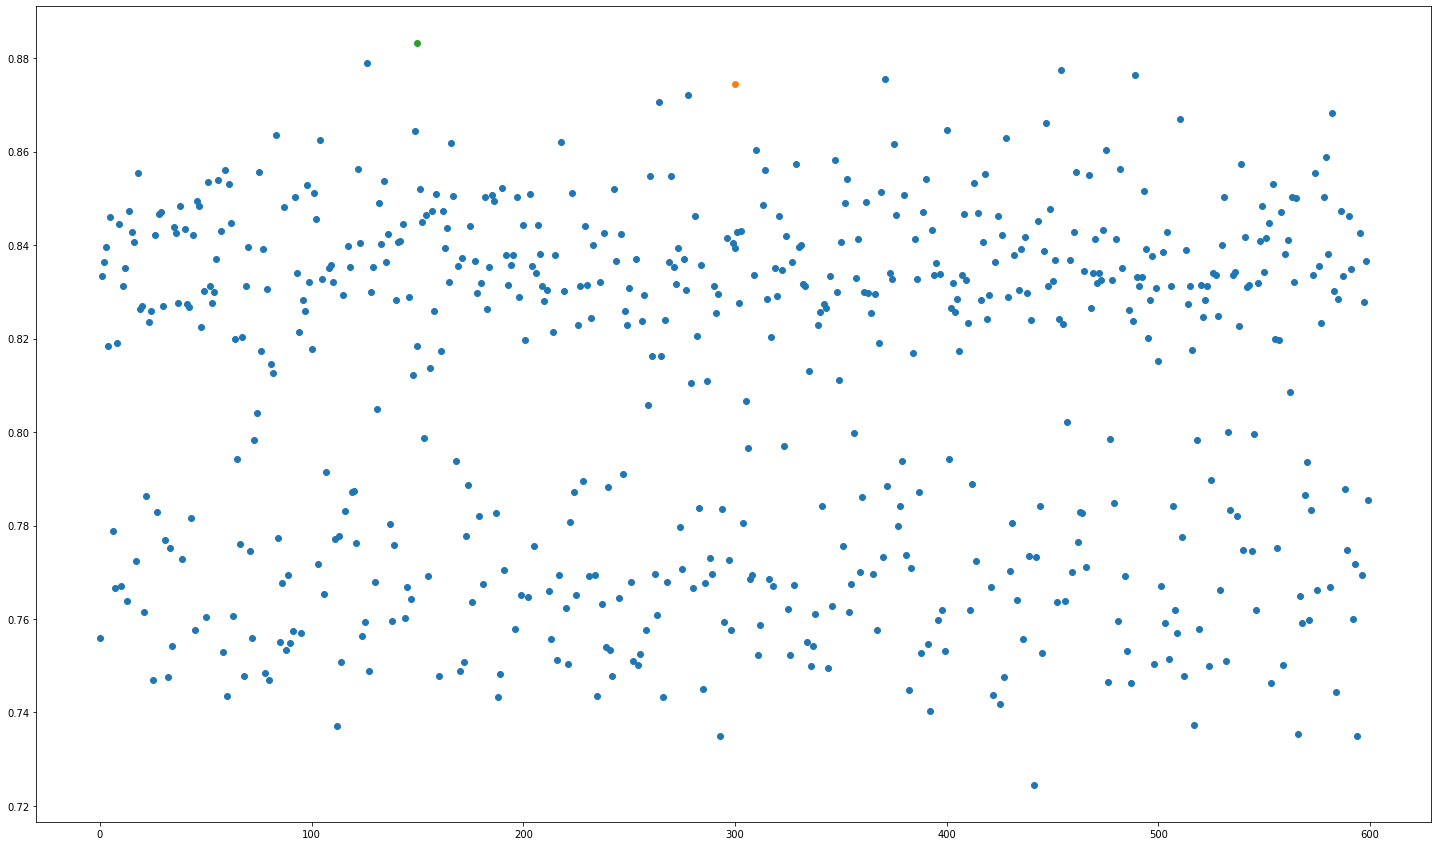

In [295]:
plt.scatter(range(len(zb['SQ'])),zb['SQ'])
plt.scatter([len(zb['SQ'])/2],[ pd.DataFrame(raw_scores['LF'],).median().loc['SQ']])
plt.scatter([len(zb['SQ'])/4],[ pd.DataFrame(raw_scores['LF'],).max().loc['SQ']])
#plt.plot(range(len(zb['SQ'])),zb['SQ'])

In [53]:
plt.scatter(range(len(zb['SUB'])),zb['SUB'])
plt.scatter([len(zb['SQ'])/2],[ pd.DataFrame(raw_scores['LF'],).median().loc['SUB']])
plt.scatter([len(zb['SQ'])/4],[ pd.DataFrame(raw_scores['LF'],).max().loc['SUB']])

NameError: name 'zb' is not defined

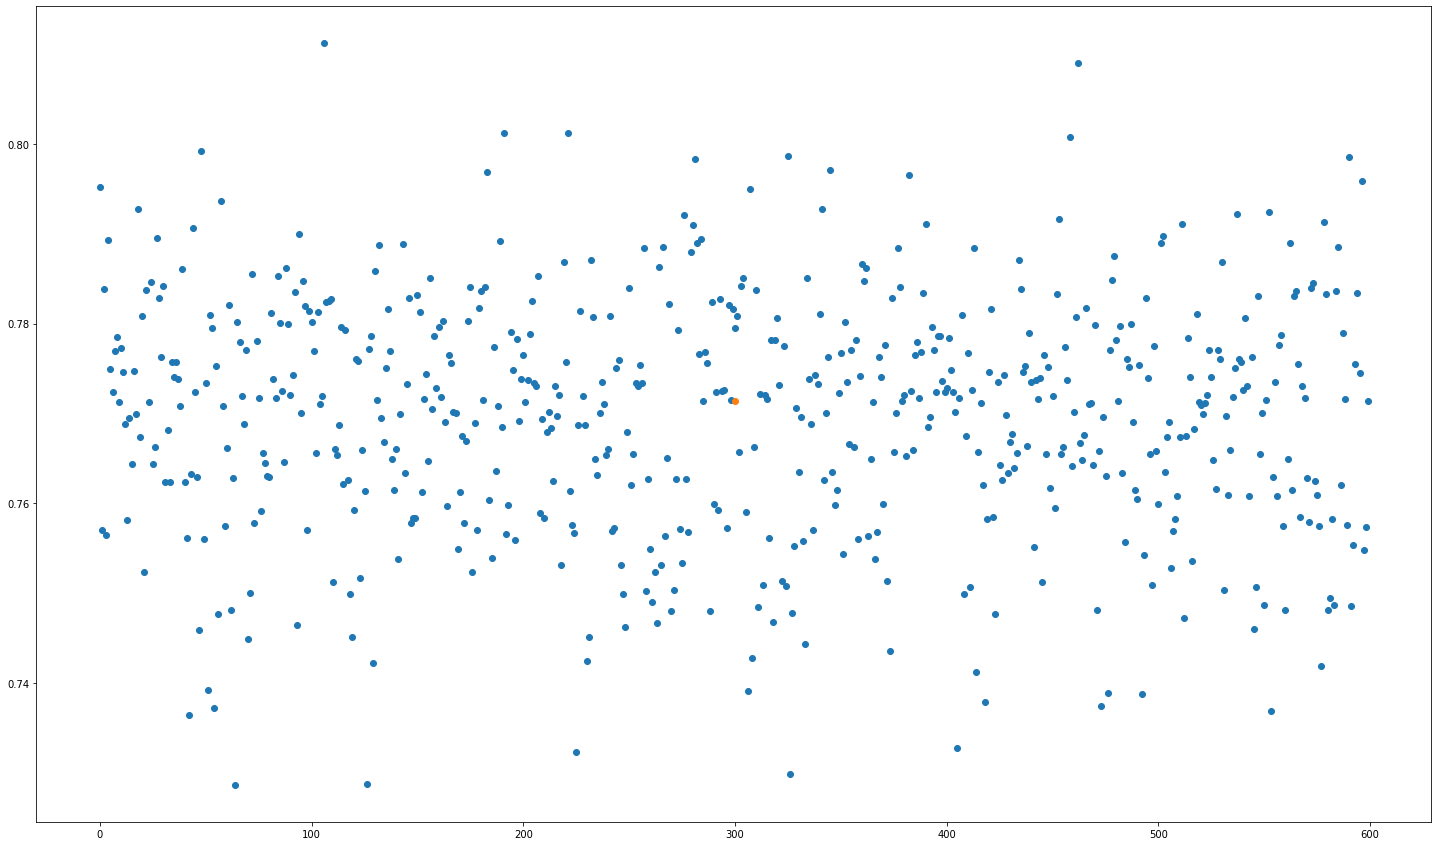

In [235]:
plt.scatter(range(len(zb['BLD'])),zb['BLD'])
plt.scatter([len(zb['SQ'])/2],[ pd.DataFrame(raw_scores['LF'],).median().loc['BLD']])

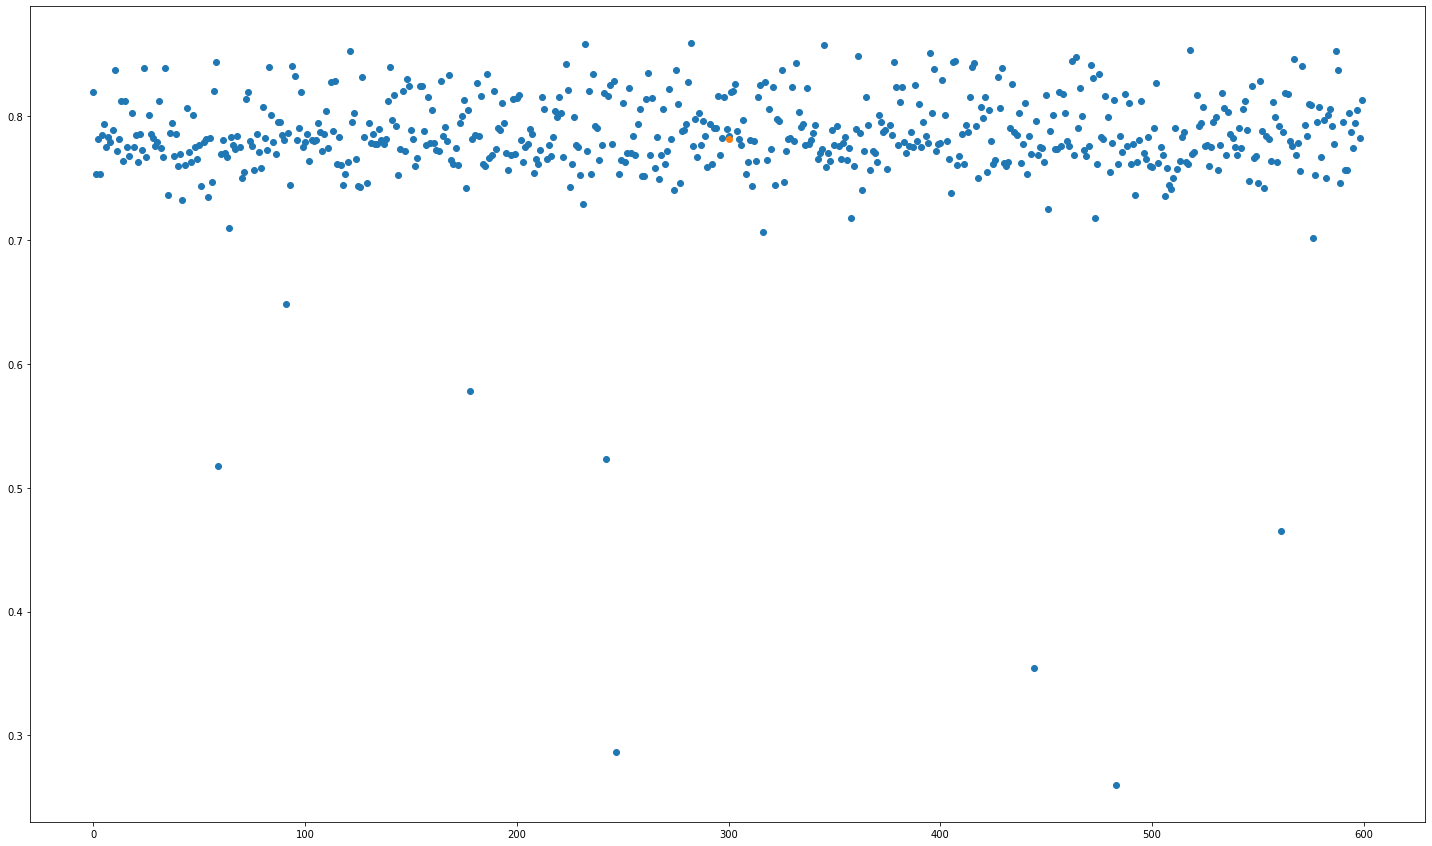

In [234]:
plt.scatter(range(len(zb['RW'])),zb['RW'])
plt.scatter([len(zb['SQ'])/2],[ pd.DataFrame(raw_scores['LF'],).median().loc['RW']])

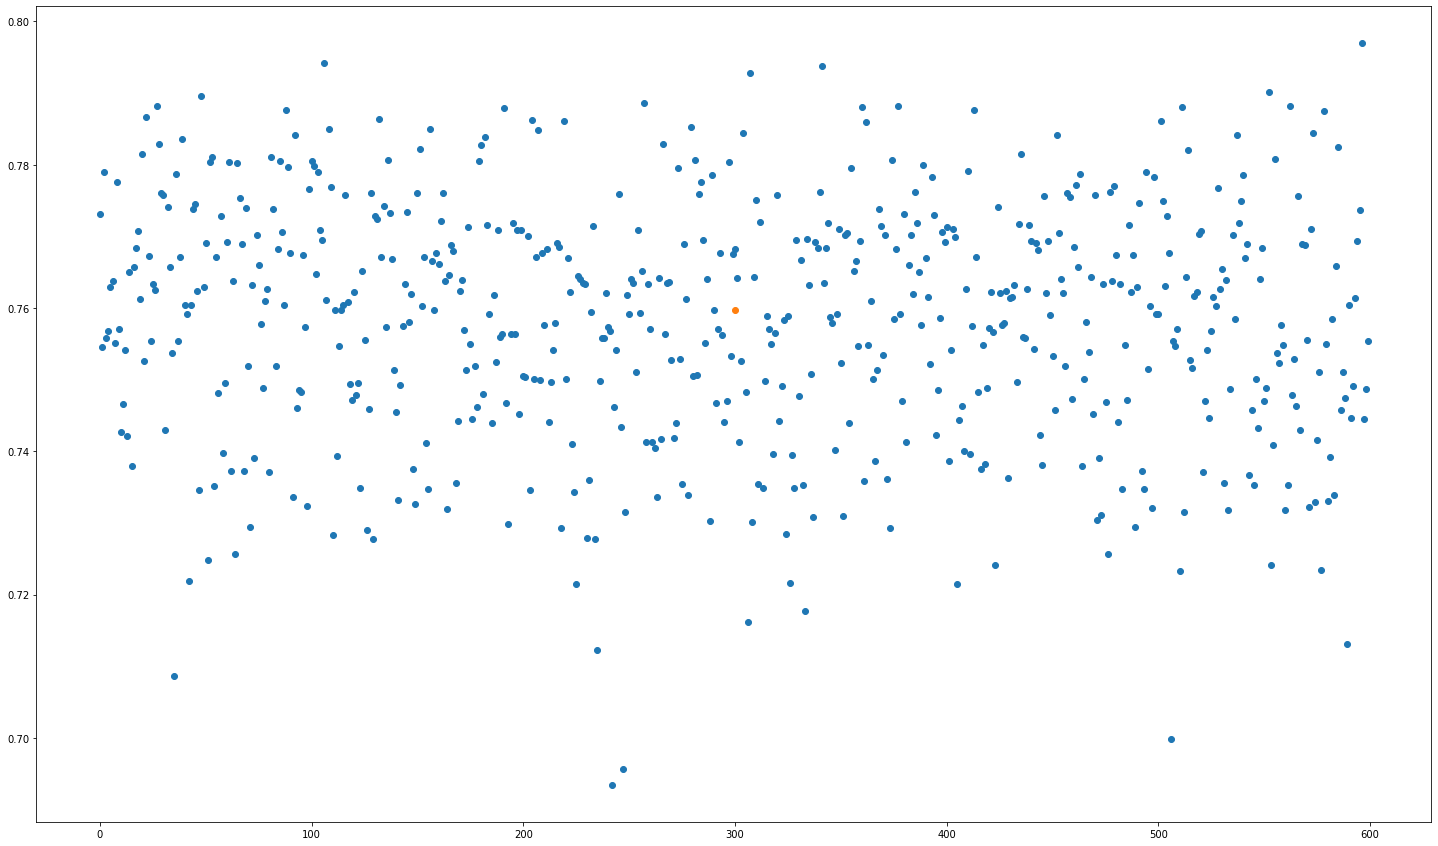

In [238]:
plt.scatter(range(len(zb['RW'])),zb['ABS'])
plt.scatter([len(zb['SQ'])/2],[ pd.DataFrame(raw_scores['LF'],).median().loc['ABS']])

In [57]:
from scipy.stats import ttest_ind
ttest_ind(raw_scores['LAE']['ABS'],raw_scores['LAE']['SUB'])

Ttest_indResult(statistic=18.010310225082176, pvalue=2.305896343780008e-64)

In [58]:
ttest_ind(raw_scores['LAE']['SQ'],raw_scores['LAE']['SUB'])

Ttest_indResult(statistic=16.877545917722177, pvalue=1.6884059394313558e-57)

In [59]:
ttest_ind(raw_scores['LAE']['RW'],raw_scores['LAE']['SUB'])

Ttest_indResult(statistic=-2.338651517477543, pvalue=0.01951722899307595)

In [60]:
ttest_ind(raw_scores['LAE']['BLD'],raw_scores['LAE']['SUB'])#.pvalue

Ttest_indResult(statistic=6.679938150581977, pvalue=3.651164500701056e-11)

In [ ]:
# Checking the skewness and Kurtosis of the scores

In [61]:
from scipy.stats import describe
print(describe(raw_scores['LAE']['BLD']))
print()
print(describe(raw_scores['LAE']['SQ']))
print()
print(describe(raw_scores['LAE']['RW']))
print()
print(describe(raw_scores['LAE']['ABS']))
print()
print(describe(raw_scores['LAE']['SUB']))

DescribeResult(nobs=600, minmax=(0.15215950967446054, 0.2580322980680827), mean=0.19313496620547543, variance=0.00021036652518282358, skewness=0.9359607710023723, kurtosis=1.5984623854641242)

DescribeResult(nobs=600, minmax=(0.14517752881249776, 0.2786557593801866), mean=0.21452977816419658, variance=0.0009363115000761237, skewness=0.13059838013366934, kurtosis=-1.246253813534367)

DescribeResult(nobs=600, minmax=(0.09915108844039704, 1.0039470105309807), mean=0.17688655808210063, variance=0.0030830394059293866, skewness=5.940279717071866, kurtosis=80.99267499159225)

DescribeResult(nobs=600, minmax=(0.1417003555794317, 0.28949814024081716), mean=0.21949746592927932, variance=0.001306075395883957, skewness=0.13808635927229457, kurtosis=-1.3732207325975136)

DescribeResult(nobs=600, minmax=(0.07449634476622574, 0.25014304619470235), mean=0.18309474994450142, variance=0.001145111566040111, skewness=-0.5661340056554003, kurtosis=-0.01246570591536722)


In [ ]:
from scipy.stats import describe


In [62]:
from scipy.stats import describe
print(describe(raw_scores['LF']['ABS']))

DescribeResult(nobs=600, minmax=(0.7754954961107949, 0.8758865626283209), mean=0.8207269361147455, variance=0.0005876924426816296, skewness=-0.08421670093141388, kurtosis=-1.3848154813528906)


In [63]:
from scipy.stats import describe
print(describe(raw_scores['LF']['SUB']))

DescribeResult(nobs=600, minmax=(0.7999084609108452, 0.9306685917275656), mean=0.845944107035265, variance=0.0006074217681797551, skewness=0.712160225208123, kurtosis=0.22031241994409667)
